## Big-Five Backstage: Dataset Demo

In this notebook, we will demonstrate different properties of the Big-Five Backstage dataset and show some potential applications mentioned [in our paper](). 

Let's dive into the structure of the dataset:
- ``dataset/big-five_backstage.csv`` - the main dataset file including lines of characters, their names, genders and Big-Five traits. It also contains author names and play titles.
- ``dataset/big-five_backstage_extended.csv`` - the extended dataset mirroring the content of the main one + pre-computed values of MRC and LIWC linguistic markers.

Additionally, we provide real-world references for certain statistics considered in this notebook: 
- ``supplementary/big-five_ling_markers_corr.csv`` - presence of significant correlation between Big-Five traits and LIWC markers for texts produced in the real-world setting.   
- ``supplementary/gender_effect_size.csv`` - Cohen's d of LIWC markers for texts produced in the real-world setting.

The dataset consists of 3265 text samples corresponding to the concatenation of lines spoken by fictional characters. Texts are extracted from 400 theatre plays written by 132 different authors. Overall, it contains 3419136 words in total with a mean equal to 1047.2 words per character. Each text entry have binary labels representing gender of a character (_Male_ or _Female_) and their five personality traits (_Extraversion_, _Agreeableness_, _Openness_, _Neuroticism_, _Conscientiousness_). The auxiliary part of the dataset includes author-level labels reflecting their gender, country of origin, and years of life.

In [39]:
from itertools import combinations

import pandas as pd
import numpy as np
import scipy.stats as stats
 
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
# load the dataset
ds_full = pd.read_csv('./dataset/Big-Five_Backstage_extended_temp.csv')

For convinience, it will be better to convert gender labels to numerical:

In [41]:
ds_full['gender'] = ds_full['gender'].replace('M', 1)
ds_full['gender'] = ds_full['gender'].replace('F', 0)

### Gender analysis

To illustrate the properties of the characters' texts, it will be a good idea to show how they can be compared to ones produced by real people. Here we will focus on the differences between the usage of different linguistic markers by men and women.

In [42]:
from utils import cohen_d, mann_whitney_u, is_correct, d_corresp

baseline = pd.read_csv('./supplementary/gender_effect_size.csv', sep=';') # loading Cohen's d for real people
ling_markers = list(baseline['feature'])

Before we begin, let's consider checking the fraction of males and females in the dataset: as it can be seen from the bar chart, it lacks balance towards the women's side.

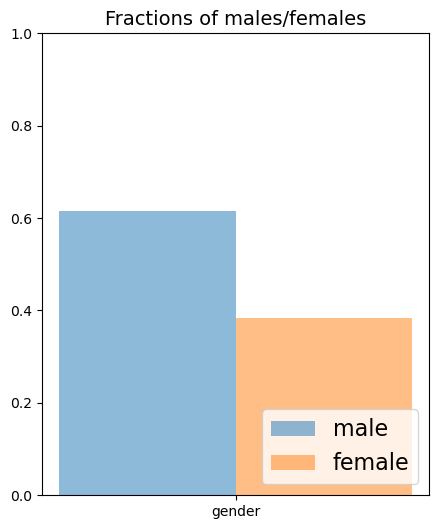

In [43]:
fractions_g_male = len(ds_full[ds_full['gender'] == 1])/len(ds_full)
fractions_g_female = 1 - fractions_g_male

X_axis = np.arange(1) 

plt.figure(figsize=(5,6))

bars_pos = plt.bar(X_axis - 0.2, fractions_g_male, 0.4, label='male', alpha=0.5)
bars_neg = plt.bar(X_axis + 0.2, fractions_g_female, 0.4, label='female', alpha=0.5)

plt.xticks(X_axis, ['gender'])
plt.ylim(0, 1)
plt.legend(loc='lower right', fontsize=16)
plt.title('Fractions of males/females', fontsize=14)

plt.show()

It will be handy to define a cutoff value for the authors included in the analysis as well as the significance level for upcoming tests: 

In [44]:
LIM, alpha = 2, 0.05 # set limit of characters for each author: no lesser than 2 males and females per author

Now we will evaluate the statistical difference between men and women for each linguistic marker and then calculate Cohen's d for those showing statistical significance (currently on the whole dataset). Our ultimate goal is to compare Cohen's d obtained for markers exhibiting significant difference (males vs females) and compare them for text produced by real people and fictional characters.

In [45]:
d_sign = {} # dict for authors, where keys are names of statistically significant LMs, and values are cohen's Ds.

d_sign_reversed_markers = {} # markers showing statistical difference but reversed to real world (having the opposite tendency of words usage by males and females)

trait = 'gender' # choose a trait for comparison
authors = set(ds_full['author'])

for author in authors:
  ds = ds_full[ds_full['author'] == author]

  if len(ds[ds[trait] == 1]) < LIM or len(ds[ds[trait] == 0]) < LIM: # checks if there are at least two samples in a trait
    continue

  d_sign[author] = {}
  d_sign_reversed_markers[author] = {}

  for marker in ling_markers:
    u, pval = mann_whitney_u(ds, trait, marker) # calculate p-value
    if pval > alpha: # checks significance of the sample difference
      continue

    d = cohen_d(ds, trait, marker)
    if is_correct(ds, baseline, trait, marker):  # checks whether marker corresponds to the real world or not (= has the same sign of difference)   
      d_sign[author][marker] = d
    else:
      d_sign[author][marker] = d
      d_sign_reversed_markers[author][marker] = d

It is worthy to observe how many markers from fiction actually follow the same pattern as in the real world (for example, at least for one author):

In [46]:
markers_pos = []
[markers_pos.extend(list(marker.keys())) for marker in [d_sign[author] for author in d_sign]]

print(len(set(markers_pos)))

43


Almost every marker was used properly at least once (which was expected in this setting). However, it is way more interesting to check those deviating from the real world:

In [47]:
markers_rev = []
[markers_rev.extend(list(marker.keys())) for marker in [d_sign_reversed_markers[author] for author in d_sign_reversed_markers]]

print(len(set(markers_rev)))

24


The dataset also provides rich material for author-level analysis. Considering the example of August Strindberg, we can construct something quite comprehensive with respect to the pairs of Cohen's d for texts of fictional characters and real people: 

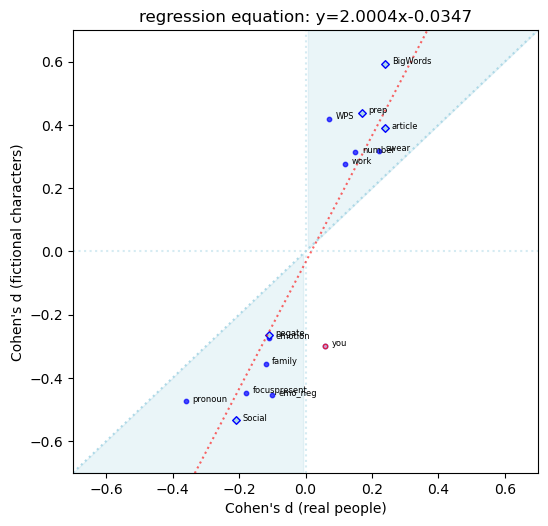

In [57]:
markers_sign = ['negate', 'article', 'prep', 'BigWords', 'cogproc', 'Social'] # these 6 markers are statistically significant for the whole dataset
author = 'STRINDBERG' # author example

b_line, data, names = d_corresp(baseline, d_sign[author])

xlim, ylim = 0.7, 0.7

plt.figure(figsize=(6, 5.75))
x1 = np.linspace(-xlim, xlim, 100)
y1 = x1 

# color exaggeration area
plt.fill_between(x1, y1, xlim, where=(x1 >= 0), color="lightblue", alpha=0.25, label="Area between y=x and y=0")
plt.fill_between(x1, y1, -xlim, where=(y1 < 0), color="lightblue", alpha=0.25, label="Area between y=x and y=0")

plt.scatter(b_line, data, c='blue', alpha=0.7, marker='o', label='Data Points', edgecolor='blue', s=10)
plt.xlabel("Cohen's d (real people)")
plt.ylabel("Cohen's d (fictional characters)")

# color dots, add text
for marker,point in zip(names,zip(b_line, data)):
  if point[0] * point[1] < 0:
    plt.scatter([point[0]], [point[1]], c='pink', alpha=0.7, marker='o', label='Data Points', edgecolor='red', s=10)
  if marker in markers_sign:
    plt.scatter([point[0]], [point[1]], c='lightblue', marker='D', label='Data Points', edgecolor='blue', s=15)

  # add text
  plt.text(point[0] + 0.02, point[1], marker, fontsize=6)


plt.xlim(-xlim, xlim)  # Set x-axis limits
plt.ylim(-xlim, xlim)  # Set y-axis limits

plt.axhline(color='lightblue', linestyle='dotted', alpha=0.5)
plt.axvline(color='lightblue', linestyle='dotted', alpha=0.5)

plt.plot([-xlim, xlim], [-xlim, xlim], color='lightblue', linestyle='dotted', label='Diagonal Line (y=x)')

# plot a correlation line
slope, intercept = np.polyfit(b_line, data, 1)
x = np.linspace(-xlim, xlim, 100)
y = slope * x + intercept
plt.plot(x, y, color='r', linestyle=':', alpha=0.6)

plt.title(f'regression equation: y={round(slope, 4)}x{round(intercept, 4)}')

plt.show()

The slope of the linear regression line indicates the level of hyperbolization for both genders ($y=x$ corresponds to the identical usage of marker in the real world and fiction) Despite the certain level of exaggeration, Strindeberg still limited them in comparison to the rest of the authors (having slope sample $Q1=2.5$ and $Q3=5.5$). Another interesting observation is related to the intercept sign: here it is negative which demonstrates an imbalance in favor of females.

### Personality traits

Previously, we compared differences between men and women using Cohen's d coefficient. In the following lines, we will demonstrate an alternative exemplary study considering a correlation-based comparison of the Big-five personality traits usage.

First, we load the file with a list of linguistic markers showing _a significant correlation_ with at least one trait for real-world texts:

In [101]:
from utils import pb_corr_full, pb_corr_author

baseline = pd.read_csv('./supplementary/big-five_ling_markers_corr.csv', delimiter=';').dropna() # Penne essays
markers = list(baseline['marker'])

As the core of our demonstration, we will apply again the extended dataset:

In [60]:
# load the dataset
ds_full = pd.read_csv('./dataset/Big-Five_Backstage_extended_temp.csv')

# get names of the Big-Five traits 
traits = list(ds_full.columns[-5:]) 
print(traits)

['Extraversion', 'Agreeableness', 'Openness', 'Neuroticism', 'Conscientiousness']


It is benefitical to demonstrate the label fractions for each trait (as we have done it earlier for genders). As can be seen, most of the traits (except Openness) tend to be less presented among the plays' characters included in the dataset.

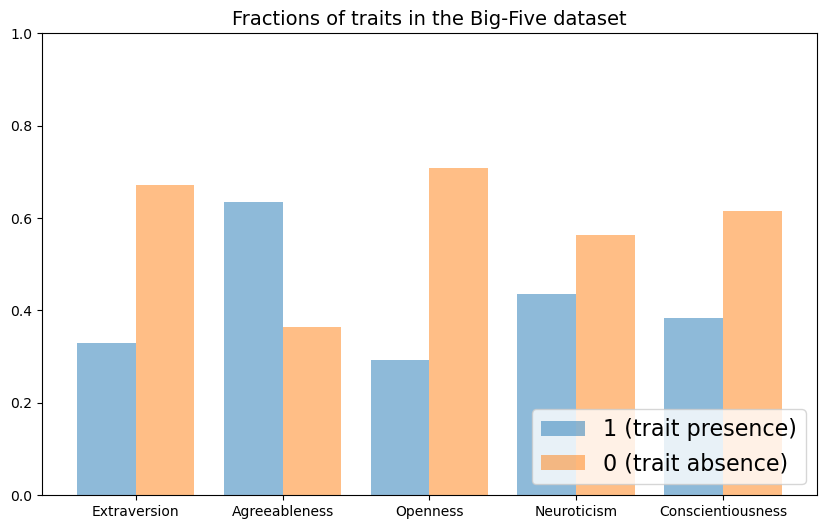

In [61]:
fractions_t_pos = np.array([len(ds_full[ds_full[trait] == 1])/len(ds_full) for trait in traits])
fractions_t_neg = 1 - fractions_t_pos

X_axis = np.arange(len(fractions_t_pos)) 

plt.figure(figsize=(10,6))

bars_pos = plt.bar(X_axis - 0.2, fractions_t_pos, 0.4, label='1 (trait presence)', alpha=0.5)
bars_neg = plt.bar(X_axis + 0.2, fractions_t_neg, 0.4, label='0 (trait absence)', alpha=0.5)

plt.xticks(X_axis, traits)
plt.ylim(0, 1)
plt.legend(loc='lower right', fontsize=16)
plt.title('Fractions of traits in the Big-Five dataset', fontsize=14)

plt.show()

From now we are going to perform a comparison of significant correlations between markers and traits for real-world texts and fiction lines. Since the personal traits are represented as binary variables, we cannot consider standard Pearson $r_{xy}$ or Spearman $r_{s}$ correlation. Instead, we will apply a special extension of $r_{xy}$ known as _point-biserial correlation_.  

Let's extract the values of statistically significant correlations. We are going to do it for each trait using the whole dataset:

In [62]:
traits_stat = {}

for trait in traits:
  markers_corr = pb_corr_full(ds_full, trait, markers)
  markers_corr = dict(sorted(markers_corr.items(), key=lambda item: item[1], reverse=True))
  traits_stat[trait] = markers_corr

It is interesting to observe which markers have a statistical significance for all 4 considered traits. Here they are:

In [65]:
intersection_5 = set.intersection(*[set(traits_stat[trait]) for trait in traits])
print(*intersection_5, sep = '\n')

AllPunc
pronoun
emo_neg
WC


The same thing can be done for the markers exhibiting statistically significant correlations for 4 traits:  

In [66]:
intersection_4_list = combinations(traits, 4)

for item in intersection_4_list:
    result = set.intersection(*[set(traits_stat[trait]) for trait in item])
    intersection_4 = intersection_4.union(result)

print(*intersection_4, sep = '\n')

T-L-FREQ
Social
MEANC
leisure
WPS
article
assent
relig
emo_anger
death
pronoun
nonflu
Apostro
Exclam
AOA
NPHON
BROWN-FREQ
WC
MEANP
negate
K-F-FREQ
AllPunc
emo_pos
emo_neg
you
CONC
Affect
K-F-NCATS
auditory


These markers and corresponding correlation values can be effectively represented as a heatmap: 

In [67]:
heatmap = {'marker':[], **{trait:[] for trait in traits}}

for marker in intersection_5:
  heatmap['marker'].append(marker)

  for trait in traits_stat:
    if marker in traits_stat[trait]:
      heatmap[trait].append(traits_stat[trait][marker])
    else:
      heatmap[trait].append(0)

In [68]:
heatmap_ds = pd.DataFrame(heatmap, columns=heatmap.keys())

heatmap_ds['RowSum'] = heatmap_ds[traits].sum(axis=1)

# Sort the DataFrame by the 'RowSum' column in descending order
df_sorted = heatmap_ds.sort_values(by='RowSum', ascending=False)

# Drop the 'RowSum' column if it's not needed
df_sorted = df_sorted.drop('RowSum', axis=1)

markers_heatmap = df_sorted['marker']
df_sorted = df_sorted.drop('marker', axis=1)

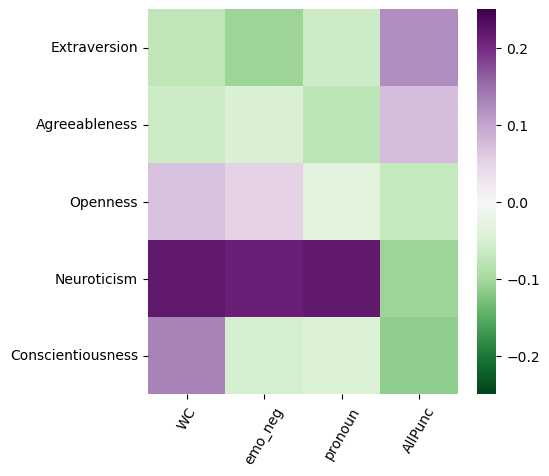

In [69]:
plt.figure(figsize=(5, 5))

ax = sns.heatmap(df_sorted.values.T, linewidth = 0, cmap="PRGn_r", vmin=-.25, vmax=.25) #interpolation='nearest', aspect='auto', extent=[0, 10, 0, 10]
ax.set_xticklabels(list(markers_heatmap), rotation=60)
ax.set_yticklabels(list(df_sorted.columns), rotation=0)

plt.show()

Due to the difference between correlation values computed for the Big-Five dataset (point-biserial) and real-world texts (Pearson), the only way to compare them is to match their signs or presence of statistically significant correlation. The table below indicates that among the chosen 4 markers (all having significant correlation for fictional characters) 50% are significant for real people too:

In [124]:
baseline.set_index('marker').T[markers_heatmap]

marker,WC,emo_neg,pronoun,AllPunc
Extraversion,0.0,0.0,1.0,1.0
Neuroticism,1.0,1.0,1.0,0.0
Agreeableness,0.0,1.0,1.0,0.0
Conscientiousness,0.0,1.0,0.0,0.0
Openness,1.0,0.0,1.0,0.0


### Markers usage

As the addition, we can always provide some usage statistics of the most demanded markers among authors. For example, it can useful to have a number of authors with at least one significant marker in at least one trait:

In [31]:
traits_stat = {}
traits_stat_by_author = {}
all_features = []

for trait in traits:
  markers_corr = list((pb_corr_full(ds_full, trait, markers)).keys())
  traits_stat[trait] = markers_corr
  traits_stat_by_author[trait] = pb_corr_author(ds_full, trait, markers)
  all_features += markers_corr
  print(trait, len(markers_corr))

c:\Users\eigho\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Extraversion 43
Agreeableness 33
Openness 39
Neuroticism 43
Conscientiousness 41


This can be demonstrated for the previously obtained markers with at least 4 statistically significant correlations among all traits:

In [32]:
target_markers = intersection_4

In [33]:
LM_sign = {}
authors_sign = {} # number of authors with at least one significant LM on at least one trait

for trait in traits_stat_by_author:
  for author in traits_stat_by_author[trait]:
    if author in authors_sign:
      authors_sign[author] += traits_stat_by_author[trait][author]
    else:
      authors_sign[author] = traits_stat_by_author[trait][author]

nonzero_authors = 0
for author in authors_sign:
  if len(authors_sign[author]) > 0:
    nonzero_authors += 1

for marker in target_markers:
  LM_sign[marker] = 0
  for author in authors_sign:
    if marker in authors_sign[author]:
      LM_sign[marker] += 1

  LM_sign[marker] = round(LM_sign[marker] / nonzero_authors, 3) # normalization

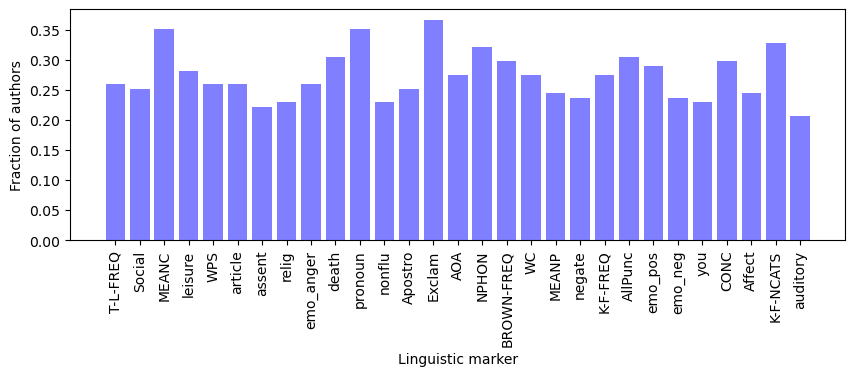

In [115]:
plt.figure(figsize=(10, 3))

plt.bar(list(LM_sign.keys()), list(LM_sign.values()), color='blue', alpha=0.5)
plt.xticks(rotation=90)

plt.xlabel('Linguistic marker')
plt.ylabel('Fraction of authors')

plt.show()

----------------
You just reached the end! If you have any questions, feel free to ask them via [issues page of our GitHub repo](https://github.com/estiei/Big-Five-Backstage/issues).